## Calculating UAR disparities of baseline and FairSpeech

In [1]:
import ast
import re
import os

def extract_uar_disparities(file_path):
    """
    Reads the evaluation results text file and extracts the list of
    Fold-wise UAR disparities.

    Args:
        file_path (str): Path to the evaluation_results.txt file.

    Returns:
        list of float: The per-fold UAR disparity values.
    """
    pattern = re.compile(r"Fold-wise UAR disparities:\s*(\[[^\]]+\])")
    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                list_str = match.group(1)
                # Safely evaluate the Python list literal
                return ast.literal_eval(list_str)
    raise ValueError("Fold-wise UAR disparities not found in file.")

In [2]:
conv_baseline_path = "logs/pointwise_conv_baseline/evaluation_results.txt"
transformer_baseline_path = "logs/transformer_baseline/evaluation_results.txt"
fairspeech_path = "logs/transformer_fairspeech/evaluation_results.txt"

# Extract UAR disparities from the baseline and FairSpeech logs
conv_baseline_UAR_diff = extract_uar_disparities(conv_baseline_path)
transformer_baseline_UAR_diff = extract_uar_disparities(transformer_baseline_path)
fairspeech_uar_diff = extract_uar_disparities(fairspeech_path)

# Change the UAR disparities into percentage
conv_baseline_UAR_diff = [x * 100 for x in conv_baseline_UAR_diff]
transformer_baseline_UAR_diff = [x * 100 for x in transformer_baseline_UAR_diff]
fairspeech_uar_diff = [x * 100 for x in fairspeech_uar_diff]

# Print the extracted UAR disparities in a readable format
print("Point-wise conv1D Baseline UAR Disparities(%):", conv_baseline_UAR_diff)
print("Transformer Baseline UAR Disparities(%):", transformer_baseline_UAR_diff)
print("FairSpeech UAR Disparities(%):", fairspeech_uar_diff)

# Calculate the mean UAR disparity for each method
conv_baseline_mean = sum(conv_baseline_UAR_diff) / len(conv_baseline_UAR_diff)
transformer_baseline_mean = sum(transformer_baseline_UAR_diff) / len(transformer_baseline_UAR_diff)
fairspeech_mean = sum(fairspeech_uar_diff) / len(fairspeech_uar_diff)

# Calculate the standard deviation of UAR disparities for each method
baseline_std = (sum((x - conv_baseline_mean) ** 2 for x in conv_baseline_UAR_diff) / len(conv_baseline_UAR_diff)) ** 0.5
transformer_baseline_std = (sum((x - transformer_baseline_mean) ** 2 for x in transformer_baseline_UAR_diff) / len(transformer_baseline_UAR_diff)) ** 0.5
fairspeech_std = (sum((x - fairspeech_mean) ** 2 for x in fairspeech_uar_diff) / len(fairspeech_uar_diff)) ** 0.5

# Print the results
print(f"Baseline Mean UAR Disparity(%): {conv_baseline_mean:.4f} ± {baseline_std:.4f}")
print(f"Transformer Mean UAR Disparity(%): {transformer_baseline_mean:.4f} ± {transformer_baseline_std:.4f}")
print(f"FairSpeech Mean UAR Disparity(%): {fairspeech_mean:.4f} ± {fairspeech_std:.4f}")


Point-wise conv1D Baseline UAR Disparities(%): [6.9940476190476275, 13.244047619047606, 13.541666666666675, 5.654761904761907, 10.71428571428572]
Transformer Baseline UAR Disparities(%): [3.571428571428581, 0.29761904761903546, 4.91071428571429, 7.440476190476176, 6.696428571428581]
FairSpeech UAR Disparities(%): [0.7440476190476275, 0.7440476190476275, 0.14880952380951218, 3.57142857142857, 2.9761904761904656]
Baseline Mean UAR Disparity(%): 10.0298 ± 3.2090
Transformer Mean UAR Disparity(%): 4.5833 ± 2.5348
FairSpeech Mean UAR Disparity(%): 1.6369 ± 1.3671


## Conduct paired t-test and plot the result

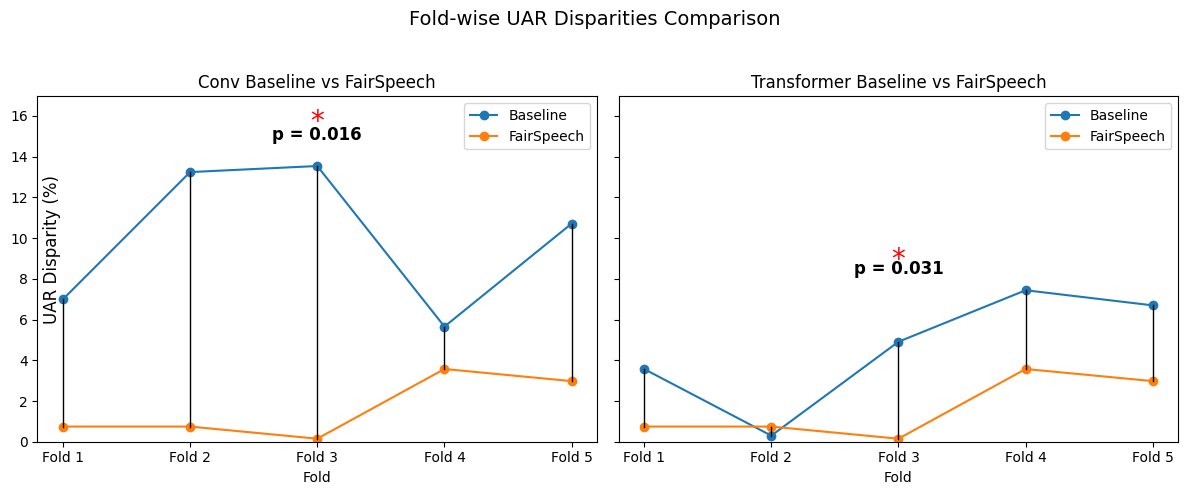

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

conv_baseline = np.array(conv_baseline_UAR_diff)
transformer_baseline = np.array(transformer_baseline_UAR_diff)
fairspeech = np.array(fairspeech_uar_diff)

folds = np.arange(1, 6)

# Perform paired t-tests
p_conv  = ttest_rel(conv_baseline, fairspeech).pvalue
p_trans = ttest_rel(transformer_baseline, fairspeech).pvalue

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, baseline, title, p_val in zip(
    axs,
    [conv_baseline, transformer_baseline],
    ['Conv Baseline vs FairSpeech', 'Transformer Baseline vs FairSpeech'],
    [p_conv, p_trans]
):
    # baseline vs FairSpeech
    ax.plot(folds, baseline,        '-o', label='Baseline',  color='C0')
    ax.plot(folds, fairspeech,      '-o', label='FairSpeech', color='C1')
    for x, y0, y1 in zip(folds, baseline, fairspeech):
        ax.plot([x, x], [y0, y1], 'k-', lw=1)

    # Annotate the p-value
    y_max   = max(baseline.max(), fairspeech.max())
    y_annot = y_max * 1.08
    ax.text(
        x=folds.mean(),    
        y=y_annot,
        s=f'p = {p_val:.3f}',
        ha='center', va='bottom',
        fontsize=12, fontweight='bold'
    )
    if p_val < 0.05:
        ax.text(
            x=folds.mean(),
            y=y_annot + y_max * 0.03,
            s='*',
            ha='center', va='bottom',
            fontsize=20, color='red'
        )

    # Set the x-ticks and labels
    ax.set_xticks(folds)
    ax.set_xticklabels([f'Fold {i}' for i in folds])
    ax.set_xlabel('Fold')
    ax.set_title(title)
    ax.legend()
    ax.set_ylim(0, y_annot + y_max * 1.2)

# Set the y-label for the plot
fig.text(0.04, 0.5, 'UAR Disparity (%)', va='center', rotation='vertical', fontsize=12)

plt.suptitle('Fold-wise UAR Disparities Comparison', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()